# Brain Tumor Classification

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce GTX 1660 Ti
Using device: cuda


## Loading the Dataset

In [5]:
# Loading the dataset
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root="/Training", transform=transform)
test_dataset = datasets.ImageFolder(root="/Testing", transform=transform)

In [6]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: /Training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [7]:
train_dataset.classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [8]:
# Image Processing
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Note: I used a different model in some of my local tests google/vit-base-patch16-224
# Not sure what sort of affect this could have had

In [9]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2870
    Root location: /Training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

## Model Initialization

In [23]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from torch.utils.data import DataLoader

checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True,num_workers=2, pin_memory=True)

model = AutoModelForImageClassification.from_pretrained(checkpoint, num_labels = 4) 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Set custom class names for predictions
model.config.id2label = {
    0: "glioma_tumor",
    1: "meningioma_tumor",
    2: "no_tumor",
    3: "pituitary_tumor"
}
model.config.label2id = {v: k for k, v in model.config.id2label.items()}

## Fine Tuning

In [27]:
import torch

# def collate_fn(batch):
#     return {
#         'pixel_values': torch.stack([
#             torch.tensor(x['pixel_values']) if not isinstance(x['pixel_values'], torch.Tensor) else x['pixel_values']
#             for x in batch
#         ]),
#         'labels': torch.tensor([x['label'] for x in batch])
#     }

def collate_fn(batch):
    images, labels = zip(*batch)  # unzip list of tuples
    return {
        'pixel_values': torch.stack(images),
        'labels': torch.tensor(labels)
    }

from sklearn.metrics import accuracy_score

def compute_metrics(p):
    preds, labels = p
    preds = preds.argmax(axis=-1)
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}


In [28]:
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
	output_dir = "./results",
  eval_strategy = "epoch",
  #report_to= None,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  num_train_epochs=10,
  label_names=['labels'],
  learning_rate=5e-5,
  logging_steps = 100,
  metric_for_best_model="accuracy",
  weight_decay=0.01,
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

In [29]:
train_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.670300,0.888559,0.710660
2,0.145500,0.681241,0.814721
3,0.052100,1.092898,0.771574
4,0.022900,1.135136,0.781726
5,0.013400,1.237525,0.763959
6,0.016700,1.230515,0.766497
7,0.007100,1.212171,0.784264
8,0.006000,1.243962,0.784264
9,0.005400,1.261659,0.784264
10,0.005200,1.267122,0.784264


In [30]:
trainer.evaluate()

{'eval_loss': 1.2671220302581787,
 'eval_accuracy': 0.7842639593908629,
 'eval_runtime': 7.7564,
 'eval_samples_per_second': 50.797,
 'eval_steps_per_second': 3.223,
 'epoch': 10.0}

In [31]:
metrics = trainer.state.log_history

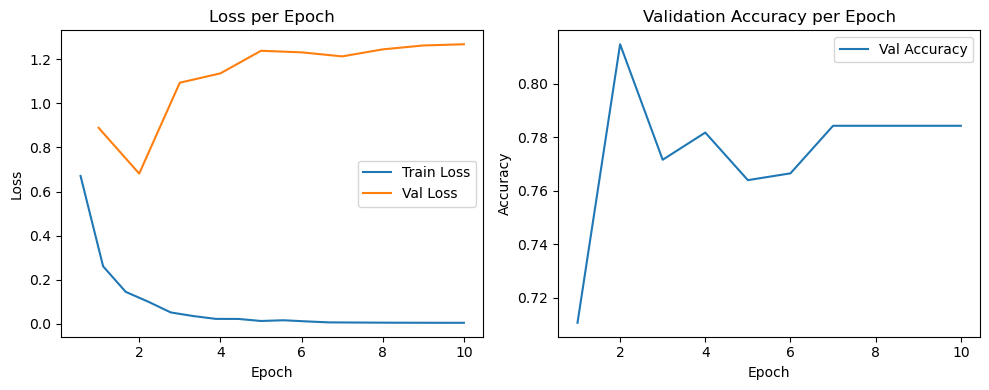

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert log history to DataFrame
log_df = pd.DataFrame(trainer.state.log_history)

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(log_df["epoch"][log_df["loss"].notna()], log_df["loss"].dropna(), label="Train Loss")
plt.plot(log_df["epoch"][log_df["eval_loss"].notna()], log_df["eval_loss"].dropna(), label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
if "eval_accuracy" in log_df.columns:
    plt.plot(log_df["epoch"][log_df["eval_accuracy"].notna()], log_df["eval_accuracy"].dropna(), label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy per Epoch")
    plt.legend()

plt.tight_layout()
plt.show()

In [33]:
preds = trainer.predict(test_dataset)

import numpy as np

y_preds = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

In [37]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 394
    Root location: /Testing
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [39]:
from sklearn.metrics import classification_report

label_names = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

print(classification_report(y_true, y_preds, target_names=label_names))

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.23      0.37       100
meningioma_tumor       0.71      1.00      0.83       115
        no_tumor       0.74      1.00      0.85       105
 pituitary_tumor       0.96      0.89      0.92        74

        accuracy                           0.78       394
       macro avg       0.85      0.78      0.75       394
    weighted avg       0.84      0.78      0.74       394



In [41]:
def params_log(
    trainer,
    train_output,
    training_args,
    unfreeze_from_layer = None,
    extra_info=None  # Optional dictionary for custom stuff
):
    metrics = trainer.evaluate()

    results_log = {
        "Train loss": train_output.training_loss,
        "Eval loss": metrics.get("eval_loss"),
        "Eval accuracy": metrics.get("eval_accuracy"),
        "Learning rate": training_args.learning_rate,
        "Weight decay": training_args.weight_decay,
        "Num epochs": trainer.state.epoch,
        "Batch size": training_args.per_device_train_batch_size,
        "Unfreeze from Layer": unfreeze_from_layer,
        "Extra Info": extra_info,
    }
    
    return results_log

In [43]:
from tabulate import tabulate

def params_log(
    trainer,
    train_output,
    training_args,
    unfreeze_from_layer=None, # Optional for if using freeze
    extra_info=None  # Optional dictionary for custom stuff
):
    metrics = trainer.evaluate()

    results_log = {
        "Train loss": train_output.training_loss,
        "Eval loss": metrics.get("eval_loss"),
        "Eval accuracy": metrics.get("eval_accuracy"),
        "Learning rate": training_args.learning_rate,
        "Weight decay": training_args.weight_decay,
        "Num epochs": trainer.state.epoch,
        "Batch size": training_args.per_device_train_batch_size,
        "Unfreeze from Layer": unfreeze_from_layer,
        "Extra Info": extra_info,
    }

    print(tabulate(results_log.items(), headers=["Parameter", "Value"], tablefmt="github"))
    return results_log


In [45]:
training_args.learning_rate

5e-05

In [47]:
model_log_overview = params_log(trainer, train_output, training_args)

model_log_overview

| Parameter           |      Value |
|---------------------|------------|
| Train loss          |  0.0774396 |
| Eval loss           |  1.26712   |
| Eval accuracy       |  0.784264  |
| Learning rate       |  5e-05     |
| Weight decay        |  0.01      |
| Num epochs          | 10         |
| Batch size          | 16         |
| Unfreeze from Layer |            |
| Extra Info          |            |


{'Train loss': 0.07743963450193406,
 'Eval loss': 1.2671220302581787,
 'Eval accuracy': 0.7842639593908629,
 'Learning rate': 5e-05,
 'Weight decay': 0.01,
 'Num epochs': 10.0,
 'Batch size': 16,
 'Unfreeze from Layer': None,
 'Extra Info': None}

In [48]:
trainer.save_model('./local_fine_tuned_model_full')

In [49]:
model_log_overview

{'Train loss': 0.07743963450193406,
 'Eval loss': 1.2671220302581787,
 'Eval accuracy': 0.7842639593908629,
 'Learning rate': 5e-05,
 'Weight decay': 0.01,
 'Num epochs': 10.0,
 'Batch size': 16,
 'Unfreeze from Layer': None,
 'Extra Info': None}